In [1]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import make_interpolation, ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, label_to_class, tran, na_imshow
from ig_pkg.metrics import pipeline, kendal_correlation

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct

import torchvision.models as models
from torch.autograd import Variable

import scipy.stats as stats

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))


In [8]:
# https://github.com/PAIR-code/saliency/blob/master/Examples_pytorch.ipynb

import saliency.core as saliency

# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im)
    plt.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

transformer = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean = IMAGENET_MEAN, std = IMAGENET_STD),
])

def LoadNumpy(file_path):
    im = Image.open(file_path)
    im = im.resize((224, 224)) # reserve channel 
    im = np.asarray(im)
    return im    

# def PreprocessImages(images):
#     # assumes input is 4-D, with range [0,255]
#     #
#     # torchvision have color channel as first dimension
#     # with normalization relative to mean/std of ImageNet:
#     #    https://pytorch.org/vision/stable/models.html
#     images = np.array(images)
#     images = images/255
#     images = np.transpose(images, (0,3,1,2))
#     images = torch.tensor(images, dtype=torch.float32)
#     images = transformer.forward(images)
#     return images.requires_grad_(True)

def LoadTensor(file_path):
    im = Image.open(file_path)
    temp = np.asarray(im)
#     if len(temp.shape) == 3: images = transformer(im)    
#     else: return None
    
    images = transformer(im)    
    return images.requires_grad_(True)

class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    target_class_idx =  call_model_args[class_idx_str]
    output = model(images)
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs

In [2]:
data_path="/root/data/ILSVRC2012_val/"

_, valid_datasets = get_datasets("imagenet1k", data_path)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets, batch_size=1, shuffle=False, num_workers=2)


In [6]:
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
eval_mode = model.eval()

In [9]:
# n02443484: 40 black-footed_ferret
# n01614925: 398 bald_eagle

data_path="/root/data/ILSVRC2012_val/"

ferrot_dir = os.path.join(data_path, 'val', 'n02443484')
ferrot_idx = os.listdir(ferrot_dir)[1]
ferrot_np = LoadNumpy(os.path.join(ferrot_dir, ferrot_idx))
ferrot_tensor = LoadTensor(os.path.join(ferrot_dir, ferrot_idx))

# eagle_dir = os.path.join(data_path, 'val', 'n01614925')
# eagle_idx = os.listdir(eagle_dir)[1]
# eagle_img = LoadNumpy(os.path.join(eagle_dir, eagle_idx))
# eagle_tensor = LoadTensor(os.path.join(eagle_dir, eagle_idx))


In [19]:

import torch 

def morf(input, label, attr, model, device, ratio, **kwargs):
    x = mask_MoRF(input, attr, ratio).unsqueeze(0)
    x = x.to(device)
    y_hat = model.forward(x).argmax(dim=-1)
    label = torch.tensor(label)
    score = (y_hat == label).sum().item()
    return  score


def lerf(input, label, attr, model, device, ratio, **kwargs):
    x = mask_LeRF(input, attr, ratio).unsqueeze(0)
    x = x.to(device)
    y_hat = model.forward(x).argmax(dim=-1)
    label = torch.tensor(label)
    score = (y_hat == label).sum().item()
    return  score

# ------------------------------------------------------------------------

def mask_MoRF(x, attr, ratio):
    original_size = x.size()
    x = x.reshape(3, -1)
    attr = torch.tensor(attr).flatten()
    v, index = torch.sort(attr, descending=True, dim=0)    
    index = index[:int(x.size(1)*ratio)]
    x[:, index] = 0.0 
    x = x.reshape(*original_size)
    return x 

def mask_LeRF(x, attr, ratio):
    original_size = x.size()
    x = x.reshape(3, -1)
    attr = torch.tensor(attr).flatten()
    v, index = torch.sort(attr, descending=True, dim=0)    
    index = index[-int(x.size(1)*ratio):]
    x[:, index] = 0.0 
    x = x.reshape(*original_size)
    return x 


In [26]:
# device = 'cuda:0'
# eval_mode = eval_mode.to(device)
# baseline = torch.zeros_like(ferrot_tensor)
# attribution = ig(eval_mode, ferrot_tensor, 359, baseline, device).detach().cpu().numpy()

temp = morf(ferrot_tensor.detach(), torch.tensor([359]).to(device), attribution, eval_mode, device, 0.1)
temp

/tmp/ipykernel_3377/931212912.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label)


0

In [56]:
for i, (input, label) in enumerate(valid_dataloader):
    logit = eval_mode(input.to(device))
    pred = torch.argmax(logit, dim = -1).item()
    attr = ig(eval_mode, input.squeeze(0).clone().detach(), pred, baseline, device).detach().cpu().numpy()
#     sc = morf(input.squeeze(0), pred, attr, eval_mode, device, 0.1)
    sc = metric(input, logit, pred, attr, model, device, 0.05)
    print(sc)
    if i == 10: break

(0.7453138530254364, -1.8158156514420194)
(0.4100320637226105, -1.4433911513148818)
(-0.536299929022789, 1.4471031786575417)
(0.17064857482910156, -0.1875543711222064)
(0.3154577612876892, -0.3792345834590635)
(0.3608443345874548, -4.581288320586551)
(0.5320352017879486, -0.866414886211625)
(0.020911097526550293, -0.021250591688547676)
(0.26445919275283813, -0.3282955684291281)
(0.16873931884765625, -0.19833162520770628)
(0.63341024518013, -1.0446951586496305)


In [55]:
def metric(input, logit, pred, attr, model, device, ratio):    
    model = model.to(device)    
    score_orig = nn.functional.softmax(logit, dim = -1)    
    prob_orig = score_orig[0, pred].item()
    
    input_hat = mask_MoRF(input.squeeze(0), attr, ratio)
    input_hat = input_hat.to(device)
    logit_new = model(input_hat.unsqueeze(0))
    score_new = nn.functional.softmax(logit_new, dim = -1)
    prob_new = score_new[0, pred].item()
    
    metric_aopc = prob_orig - prob_new  
    metric_lodds = np.log(prob_new / (prob_orig + 1e-5))        
    
    return metric_aopc, metric_lodds

In [13]:
ferrot_dir = os.path.join(data_path, 'val', 'n02443484')
ferrot_list = os.listdir(ferrot_dir)
ferrot_list = [file for file in ferrot_list if file.endswith(".JPEG")]

ferrot = []

for i in range(len(ferrot_list)):
#     print(ferrot_list[i])
    path = os.path.join(ferrot_dir, ferrot_list[i])
    img = LoadTensor(path) 
    img = img.unsqueeze(0)

    score = eval_mode(img)
    idx = torch.argmax(score, dim = -1)
    
    if idx.item() == 359:
        ferrot.append(img.squeeze(0))
ferrot = torch.stack(ferrot, dim = 0)
print(ferrot.shape)    


torch.Size([33, 3, 224, 224])


In [57]:
# attribution = np.load('/root/data/results/ig_inversion/ig_zero_baseline.npy')
# attribution[0].shape

(224, 224)

In [7]:
from ig_pkg.metrics import delete_attribution

device = 'cuda:0'
temp = ferrot_tensor.to(device)
baseline = torch.zeros_like(temp)
eval_mode = eval_mode.to(device)

logit_orig = eval_mode(temp.unsqueeze(0))
score_orig = nn.functional.softmax(logit_orig, dim = -1)
init_pred = torch.argmax(logit_orig).item()
prob_orig = score_orig[0, init_pred].item()
# print(prob_orig)

attr = ig(eval_mode, temp, init_pred, baseline, device)
new_tensor = delete_attribution(temp, attr, 5, device)
# logit_new = model(new_tensor.unsqueeze(0))
# score_new = nn.functional.softmax(logit_new, dim = -1)
# prob_new = score_new[0, init_pred].item()

# metric_aopc = prob_orig - prob_new
# metric_lodds = np.log(prob_new / (prob_orig + 1e-5))        
# #     metric_kendall = 


gaussian_blur
maximumdistance
min
gaussian
uniform
one
scalar
zero
max


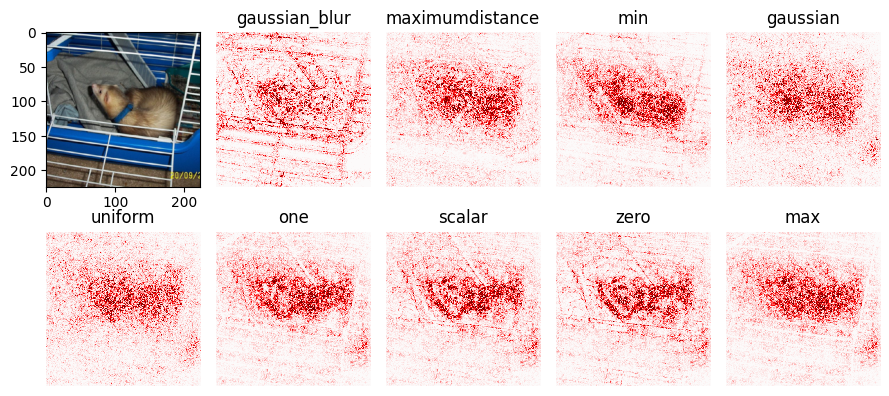

In [30]:
device = 'cuda:0'
names = {
    'zero',
    'one',
    'min',
    'max',
    'scalar',
#     'encoder',
#     'optimizer',
#     'hybrid',
    'gaussian_blur',
    'gaussian',
    'uniform',
    'maximumdistance' 
}

# {'gaussian',
#  'gaussian_blur',
#  'max',
#  'maximumdistance',
#  'min',
#  'one',
#  'scalar',
#  'uniform',
#  'zero'}

index = 0 
# x,y = valid_datasets[index]
x = ferrot_tensor
y = 359

fig, axes = plt.subplots(2, (len(names)//2)+1, figsize=(2*len(names)//2, 2*2))
axes_flat = axes.flat 
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

ax = next(axes_flat)
ax.imshow(convert_to_img(x))

AOPC = []
LODDs = []
Kendal = []
for name in names:
    print(name)
    a = []
    b = []
    try:
        b_generator =  get_baseline_generator(name, scalar = 0.3)
        baseline = b_generator(x=x,y=y)

    except Exception as e: 
        print("-----")
        print("fail:", name)
        print(e)
        continue
        
    attr = ig(eval_mode.to(device), x, y, baseline, device=device)
    Kendal.append(kendal_correlation(eval_mode, ferrot_tensor, baseline, attr.detach().cpu().numpy(), device))

#     print(name)
    for i in range(19):
#         k = i * 5 + 5        
        k = i + 1
        aopc, lodds = pipeline(eval_mode, ferrot_tensor.to(device), baseline, attr, k, device, name)
        
#         print(name, k, aopc, lodds)
        a.append(aopc)
        b.append(lodds)
    
    attr, kwargs  = process_heatmap(attr.cpu(), my_cmap)
    ax = next(axes_flat)
    ax.imshow(attr, **kwargs)
    ax.set_title(name)
    ax.axis("off")
    
    AOPC.append(a)
    LODDs.append(b)    
    
plt.tight_layout()

json practice

In [60]:
import json
practice = {'a': 1, 'b': 2}
practice['c'] = []
practice['c'].append(3)

# with open(os.path.join(self.save_dir, f"prac.json"), 'w') as f:
with open(f"prac.json", 'w') as f:
        json.dump(practice, f, indent=2, sort_keys=True)
    
# prac = json.load(open('prac.json' ,"r"))
prac['d'] = [4]
with open(f"prac.json", 'w') as f:
        json.dump(prac, f, indent=2, sort_keys=True)


# json.load(open(os.path.join(self.save_dir, 'evaluation_samples.json') ,"r"))


In [63]:
# prac = json.load(open('prac.json' ,"r"))
prac['d'] = [4]
with open(f"prac.json", 'w') as f:
        json.dump(prac, f, indent=2, sort_keys=True)
